In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pygem_eb.processing.plotting_fxns import *
from objectives import *
import process_outputs as po
import pickle
import os
import copy
import socket
machine = socket.gethostname()
if 'trace' in machine:
    base_fp = '/trace/group/rounce/cvwilson/Output/'
elif os.path.exists('/mnt/d/'):
    base_fp = '/mnt/d/grid_search/'
else:
    base_fp = '/home/claire/research/Output/EB/'

In [2]:
# Create some dictionaries with useful information
labels = {'kp':'Precipitation factor','kw':'Wind factor','Boone_c5':'Densification c$_5$'}      # Labels for the different parameters we varied
methodlabels = {'MAE':'MAE','ME':'Bias','RMSE':'RMSE'}                                          # Labels for the different error methods
errorlabels = {'seasonal':'Seasonal mass balance (m w.e.)',                                     # Labels for the different error metrics with units
               'winter':'Winter mass balance (m w.e.)', 
               'summer':'Summer mass balance (m w.e.)', 
               'annual':'Annual mass balance (m w.e.)',
               'snowdepth':'End-of-winter snow depth (m)',
               'snowmass':'End-of-winter snow mass (m w.e.)',
               'snowdensity':'End-of-winter snow density (kg m-3)',
               '2024':'2024 surface height change (m)'} 
shorterrorlabels = {'2024':'2024 surface height','snowdensity':'Snow density','snowdepth':'Snow depth',
                    'seasonal':'Seasonal MB','winter':'Winter MB','summer':'Summer MB','annual':'Annual MB'}
param_labels = {'kw':'Wind factor','kp':'Precipitation factor','c5':'Densification parameter'}
medians = {'kp':'2.6','kw':'1','Boone_c5':'0.024'}                                              # Median value of each of the parameters
sitedict = {'2024':['AB','ABB','B','BD','D','T'],'long':['A','AU','B','D']}                     # Dictionary of sites in the 2024 and long run
all_sites = sitedict['long']+sitedict['2024']+['mean']                                          # List all sites

In [3]:
# USER OPTIONS
method = 'ME'                                                       # Choose from MAE, ME
run_info = {'long':{'date':'01_24', 'idx':'0'},                     # Date and index of the grid search (12_04) (01_16)
            '2024':{'date':'01_25', 'idx':'0'}}                     # (12_06)
params = {'kw':[1,1.5,2,2.5,3],                                     # Parameters used in the grid search
          'Boone_c5':[0.018,0.02,0.022,0.024,0.026,0.028],
          'kp':[2.4,2.6,2.8,3,3.2]}
for key in params:                                                  # Convert params to strings for processing
    for v,value in enumerate(params[key]):
        params[key][v] = str(value)

In [4]:
# Open results dict
both_dict = {}
for run_type in ['long','2024']: # 
    date = run_info[run_type]['date']
    idx = run_info[run_type]['idx']
    # Compiled pickle exists: load it
    with open(base_fp + f'{date}_{idx}_out.pkl', 'rb') as file:
        grid_dict = pickle.load(file)
    
    # Store the dictionary under the run type (long or 2024)
    both_dict[run_type] = grid_dict

# Condense long and 2024 runs into to a single result_dict
result_dict = both_dict['long']
for c5 in params['Boone_c5']:
    for kp in params['kp']:
        for kw in params['kw']:
            # Add the 2024 error stats to the result_dict
            for site in sitedict['2024']:
                # Some sites are different from long run, so add a slot for these runs
                if site not in result_dict[kw][c5][kp]:
                    result_dict[kw][c5][kp][site] = {}
                # Add the 2024 error stats
                for var in both_dict['2024'][kw][c5][kp][site]:
                    result_dict[kw][c5][kp][site]['2024_'+var] = both_dict['2024'][kw][c5][kp][site][var] 

In [5]:
# ===== Find site means of each error type =====
# List out all error types
all_error = list(result_dict['1']['0.026']['2.4']['B'].keys())
all_error.remove('run_no')
all_error.remove('set_no')
all_error.remove('2024_run_no')
all_error.remove('2024_set_no')
    
# Create dictionary to store site means
sites_error_dict = {}
# Loop through all parameters and sites
for kw in params['kw']:
    for c5 in params['Boone_c5']:
        for kp in params['kp']:
            result_dict[kw][c5][kp]['mean'] = {}
            for error_type in all_error:
                sites_error_dict[error_type] = []
                for site in all_sites[:-1]:
                    if '2024' in error_type and site in sitedict['2024']:
                        sites_error_dict[error_type].append(result_dict[kw][c5][kp][site][error_type])
                    elif '2024' not in error_type and site in sitedict['long']:
                        sites_error_dict[error_type].append(result_dict[kw][c5][kp][site][error_type])
                if len(sites_error_dict[error_type]) > 0:
                    result_dict[kw][c5][kp]['mean'][error_type] = np.mean(sites_error_dict[error_type])

In [6]:
# Create function to find the pareto front points
def pareto_sweep(points):
    """
    Returns the indices of the pareto front points in the passed array
    """
    # Sort points by x-coordinate, then by y-coordinate
    sorted_indices = np.argsort(points[:, 0])
    sorted_points = points[sorted_indices]
    
    pareto_indices = []
    current_min_y = np.inf

    for i, point in enumerate(sorted_points):
        if point[1] < current_min_y: # F
            pareto_indices.append(sorted_indices[i])  # Store the original index
            current_min_y = point[1]

    return np.array(pareto_indices)

In [10]:
plot_errors = ['annual','snowdensity','snowdepth','2024']
metric = 'MAE'

# List all error metrics to compare
all_pareto_fronts = []
for i, (error_x, error_y) in enumerate(itertools.combinations(plot_errors,2)):
    list_x = []
    list_y = []
    list_params = {'kw':[],'c5':[],'kp':[]}
    for kw in params['kw']:
        for c5 in params['Boone_c5']:
            for kp in params['kp']:
                error_x_point = result_dict[kw][c5][kp]['mean'][error_x + '_' + metric]
                error_y_point = result_dict[kw][c5][kp]['mean'][error_y + '_' + metric]

                # Add to lists
                list_params['kw'].append(float(kw))
                list_params['c5'].append(float(c5))
                list_params['kp'].append(float(kp))
                list_x.append(error_x_point)
                list_y.append(error_y_point)
   
    # Non=dominated
    idx_non_dom = pareto_sweep(np.array([list_x,list_y]).T)
    # print(f'Comparing {error_x} and {error_y} {metric} results in the following non-dominated sets:')
    fronts = []
    for i in idx_non_dom:
        kw = list_params['kw'][i]
        c5 = list_params['c5'][i]
        kp = list_params['kp'][i]
        # print(f'    kw={kw}    c5={c5}    kp={kp}    {error_x} {metric}={list_x[i]:.3f}   {error_y} {metric}={list_y[i]:.3f}')
        fronts.append((kw,c5,kp))
    all_pareto_fronts.append(fronts)

In [11]:
fronts

[(2.5, 0.026, 2.4),
 (2.5, 0.028, 2.4),
 (2.0, 0.028, 2.4),
 (2.0, 0.026, 2.6),
 (1.5, 0.028, 2.4),
 (1.0, 0.028, 2.4),
 (1.0, 0.026, 2.6),
 (1.0, 0.028, 2.6),
 (1.0, 0.026, 2.8),
 (1.0, 0.028, 2.8),
 (1.0, 0.026, 3.2),
 (1.0, 0.028, 3.0)]

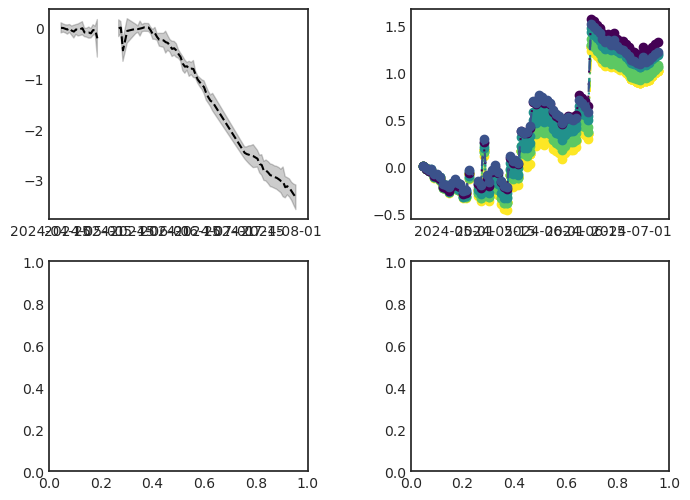

In [43]:
# Pareto front timeseries
fig, axes = plt.subplots(2,2,figsize=(8,6), gridspec_kw={'wspace':0.4, 'hspace':0.2})
styles = ['-','--',':','dashdot',(0, (1, 5)),(0, (5, 5))]
markers = ['o','^','*','x','+','>']

# 2024 panels
date = run_info['2024']['date']
idx = run_info['2024']['idx']
site = 'B'
# for s, site in enumerate(['T','B','ABB']):
# c = plt.cm.tab10(s)
# Data filepath
fp_gnssir = f'../MB_data/Stakes/gulkana{site}24_GNSSIR.csv'

# Load GNSSIR daily MB
df_mb_dict = {}
if os.path.exists(fp_gnssir):
    df_mb_daily = pd.read_csv(fp_gnssir)
    df_mb_daily.index = pd.to_datetime(df_mb_daily['Date'])
    df_mb_daily['CMB'] -= df_mb_daily['CMB'].iloc[0]
    df_mb_dict['GNSS_IR'] = df_mb_daily.sort_index()

if 'GNSS_IR' in df_mb_dict:
    df_mb_daily = df_mb_dict['GNSS_IR']
    axes[0,0].plot(df_mb_daily.index,df_mb_daily['CMB'],label='GNSS-IR',linestyle='--',color='black')
    # error bounds
    lower = df_mb_daily['CMB'] - df_mb_daily['sigma']
    upper = df_mb_daily['CMB'] + df_mb_daily['sigma']
    axes[0,0].fill_between(df_mb_daily.index,lower,upper,alpha=0.2,color='black')

for (kw, c5, kp) in fronts:
    if kp in [2.,3.]:
        kp = int(kp)
    norm = mpl.colors.Normalize(vmin=2.4,vmax=3.2)
    cmap = mpl.colormaps.get_cmap('viridis_r')
    idx_marker = 0 # np.where(params['Boone_c5'] == 'str(c5'))[0]
    idx_style = params['Boone_c5'].index(str(c5))
    setno = result_dict['1'][str(c5)][str(kp)][site]['2024_set_no']
    runno = result_dict['1'][str(c5)][str(kp)][site]['2024_run_no']
    ds,_,_ = getds(base_fp + f'{date}_{site}_{idx}/grid_{date}_set{setno}_run{runno}_0.nc')
    time,diff = cumulative_mass_balance(ds,out='diff')
    axes[0,1].plot(time, diff, color=cmap(norm(kp)), linestyle=styles[idx_style], marker=markers[idx_marker])

In [26]:
list(result_dict['1'].keys())

['0.018', '0.02', '0.022', '0.024', '0.026', '0.028']